# **Segmentação de clientes**

Nessa extensão do projeto do Modelo de Financiamento de Veículos vamos realizar uma segmentação de clientes no data set com os resultados da modelagem.

# Aplicando o modelo

In [22]:
import pandas as pd
import duckdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

Importando novamente o DF original para trabalharmos com ele

In [5]:
# Caminho do arquivo (ajustar conforme necessário)
file_path = '/content/Dataset 1.xlsx'
# Verifique se o arquivo existe antes de carregá-lo
import os
if os.path.exists(file_path):
   excel_data = pd.ExcelFile(file_path)
   print(excel_data.sheet_names)
   df = excel_data.parse('financiamento_veiculos_analytic')
   print(df.head())
else:
   print(f"Arquivo {file_path} não encontrado.")

['financiamento_veiculos_analytic']
   ID_Cliente  Idade     Genero    Regiao Faixa_de_Renda  Valor_Financiado  \
0           1     56   Feminino  Regiao C    Baixa Renda             96231   
1           2     69  Masculino  Regiao A    Media Renda             17314   
2           3     46  Masculino  Regiao A     Alta Renda             29623   
3           4     32   Feminino  Regiao A    Media Renda             77675   
4           5     60  Masculino  Regiao D    Media Renda             75082   

   Prazo_Financiamento (Meses)  Taxa_de_Juros_ao_ano (%)  Valor_Parcela  \
0                           60                     0.352    3145.433332   
1                           48                     0.200     511.964756   
2                           12                     0.200    2721.074668   
3                           48                     0.210    2331.282164   
4                           36                     0.320    3109.184027   

   Modelo_Ano_Veiculo  Valor_Veiculo Status_

In [6]:
# 1. Label Encoding com pesos reais

df['Faixa_de_Renda'] = df['Faixa_de_Renda'].map({'Baixa Renda': 1, 'Media Renda': 2, 'Alta Renda': 3})
df['Status_Pagamento'] = df['Status_Pagamento'].map({'Em dia': 0, 'Inadimplente': 1})

# 2. One-Hot Encoding nas outras variáveis categóricas

df = pd.get_dummies(df, columns=['Genero', 'Regiao'], drop_first=True)

# Exibir o resultado
display(df)

,ID_Cliente,Idade,Faixa_de_Renda,Valor_Financiado,Prazo_Financiamento (Meses),Taxa_de_Juros_ao_ano (%),Valor_Parcela,Modelo_Ano_Veiculo,Valor_Veiculo,Status_Pagamento,Renda_Media_Regional,Taxa_Inadimplencia_Regional,Genero_Masculino,Regiao_Regiao B,Regiao_Regiao C,Regiao_Regiao D
0,1,56,1,96231,60,0.352,3145.433332,2017,160385.000000,0.0,2500,0.040000,False,False,True,False
1,2,69,2,17314,48,0.200,511.964756,2020,24047.222222,0.0,5000,0.016667,True,False,False,False
2,3,46,3,29623,12,0.200,2721.074668,2012,58084.313725,0.0,5000,0.016667,True,False,False,False
3,4,32,2,77675,48,0.210,2331.282164,2020,121367.187500,0.0,5000,0.016667,False,False,False,False
4,5,60,2,75082,36,0.320,3109.184027,2022,123085.245902,0.0,1500,0.060000,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,65,3,34596,36,0.120,1138.972183,2019,78627.272727,1.0,3500,0.026667,True,True,False,False
496,497,42,2,43174,36,0.340,1823.989879,2016,65415.151515,0.0,5000,0.016667,False,False,False,False
497,498,57,3,74106,60,0.340,2380.620119,2013,139822.641509,0.0,2500,0.040000,False,False,True,False
498,499,62,2,79967,24,0.290,4297.560110,2018,111065.277778,0.0,2500,0.040000,True,False,True,False


In [7]:
# Substituir valores nulos pela mediana de cada coluna no DataFrame df
df = df.apply(lambda col: col.fillna(col.median()), axis=0)

# Exibir o DataFrame atualizado
print(df)


     ID_Cliente  Idade  Faixa_de_Renda  Valor_Financiado  \
0             1     56               1             96231   
1             2     69               2             17314   
2             3     46               3             29623   
3             4     32               2             77675   
4             5     60               2             75082   
..          ...    ...             ...               ...   
495         496     65               3             34596   
496         497     42               2             43174   
497         498     57               3             74106   
498         499     62               2             79967   
499         500     18               3             69182   

     Prazo_Financiamento (Meses)  Taxa_de_Juros_ao_ano (%)  Valor_Parcela  \
0                             60                     0.352    3145.433332   
1                             48                     0.200     511.964756   
2                             12                

In [8]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


In [9]:
from catboost import CatBoostClassifier

Aplicar o K-Means no data set desbalanceado para criar grupos na classe minoritária de forma que os clusters sejam mantidas as caracteristicas e padrões do Data set original.

Após o balanceamento, vamos aplicar o ensemble dos modelos para que ele possa classificar as classes em: "Em dia" ou "Inadiplente"

              precision    recall  f1-score   support

      Em dia       0.99      1.00      0.99        92
Inadimplente       1.00      0.88      0.93         8

    accuracy                           0.99       100
   macro avg       0.99      0.94      0.96       100
weighted avg       0.99      0.99      0.99       100



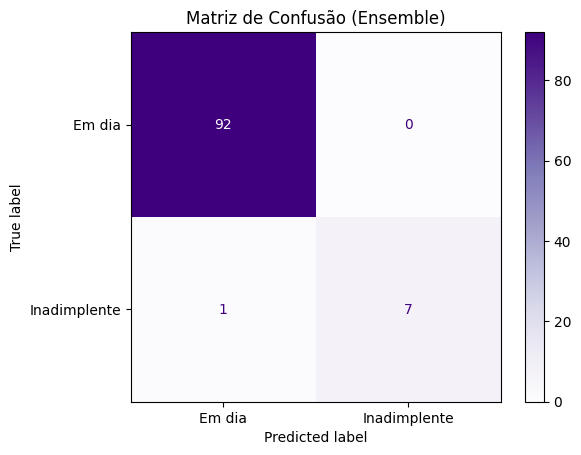

In [10]:
# Separar as variáveis preditoras e alvo
X = df.drop('Status_Pagamento', axis=1)
y = df['Status_Pagamento']


# Aplicar K-Means para criar grupos artificiais na classe minoritária
minority_class = X[y == 1]  # Classe minoritária
kmeans = KMeans(n_clusters=5, random_state=50)  # Criar 5 clusters
clusters = kmeans.fit_predict(minority_class)  # Ajustar o K-Means e obter os clusters


# Adicionar os clusters como nova feature
X['Minoritaria_Cluster'] = 0  # Inicializar com 0
X.loc[y == 1, 'Minoritaria_Cluster'] = clusters  # Adicionar os clusters na classe minoritária


# Escalar as variáveis numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
   X_scaled, y, test_size=0.2, random_state=50, stratify=y
)


# Modelo 1: CatBoost
catboost_model = CatBoostClassifier(
   iterations=200,
   learning_rate=0.1,
   depth=6,
   eval_metric='F1',
   random_seed=50,
   verbose=0  # Silenciar logs do treinamento
)
catboost_model.fit(X_train, y_train)


# Modelo 2: Random Forest
rf_model = RandomForestClassifier(
   n_estimators=200,
   max_depth=6,
   random_state=50
)
rf_model.fit(X_train, y_train)


# Modelo 3: SVM
svm_model = SVC(
   C=10,  # Parâmetro de regularização
   probability=True,  # Habilitar probabilidades (necessário para o ensemble)
   kernel='rbf',  # Kernel radial base function
   class_weight='balanced',  # Balancear as classes automaticamente
   random_state=50
)
svm_model.fit(X_train, y_train)


# Combinar os modelos com VotingClassifier
ensemble_model = VotingClassifier(
   estimators=[
       ('catboost', catboost_model),
       ('random_forest', rf_model),
       ('SVM', svm_model)
   ],
   voting='soft'  # 'soft' usa probabilidades; 'hard' usa previsões diretas
)
# Treinar o ensemble no conjunto de treino
ensemble_model.fit(X_train, y_train)


# Fazer previsões no conjunto de teste
y_pred = ensemble_model.predict(X_test)

# Avaliar o desempenho
# Relatório de métricas
print(classification_report(y_test, y_pred, target_names=['Em dia', 'Inadimplente']))
# Matriz de Confusão
cm_display = ConfusionMatrixDisplay.from_predictions(
   y_test, y_pred, display_labels=['Em dia', 'Inadimplente'], cmap=plt.cm.Purples
)
cm_display.ax_.set_title('Matriz de Confusão (Ensemble)')
plt.show()

# Colocando o modelo para realizar as previsões e adcionando as previsões ao DF.

In [11]:
# Fazer previsões no conjunto de teste
y_pred = ensemble_model.predict(X_test)

In [12]:
# Reconstruir o DataFrame do conjunto de teste
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Adicionar as previsões ao DataFrame
X_test_df['Previsao_Modelo'] = y_pred

# Adicionar o rótulo real para comparação
X_test_df['Status_Real'] = y_test.values

In [13]:
# Fazer previsões para todo o conjunto de dados
y_pred_full = ensemble_model.predict(X_scaled)

# Adicionar as previsões ao DataFrame original
df['Previsao_Modelo'] = y_pred_full

In [14]:
display(df)

,ID_Cliente,Idade,Faixa_de_Renda,Valor_Financiado,Prazo_Financiamento (Meses),Taxa_de_Juros_ao_ano (%),Valor_Parcela,Modelo_Ano_Veiculo,Valor_Veiculo,Status_Pagamento,Renda_Media_Regional,Taxa_Inadimplencia_Regional,Genero_Masculino,Regiao_Regiao B,Regiao_Regiao C,Regiao_Regiao D,Previsao_Modelo
0,1,56,1,96231,60,0.352,3145.433332,2017,160385.000000,0.0,2500,0.040000,False,False,True,False,0.0
1,2,69,2,17314,48,0.200,511.964756,2020,24047.222222,0.0,5000,0.016667,True,False,False,False,0.0
2,3,46,3,29623,12,0.200,2721.074668,2012,58084.313725,0.0,5000,0.016667,True,False,False,False,0.0
3,4,32,2,77675,48,0.210,2331.282164,2020,121367.187500,0.0,5000,0.016667,False,False,False,False,0.0
4,5,60,2,75082,36,0.320,3109.184027,2022,123085.245902,0.0,1500,0.060000,True,False,False,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,65,3,34596,36,0.120,1138.972183,2019,78627.272727,1.0,3500,0.026667,True,True,False,False,1.0
496,497,42,2,43174,36,0.340,1823.989879,2016,65415.151515,0.0,5000,0.016667,False,False,False,False,0.0
497,498,57,3,74106,60,0.340,2380.620119,2013,139822.641509,0.0,2500,0.040000,False,False,True,False,0.0
498,499,62,2,79967,24,0.290,4297.560110,2018,111065.277778,0.0,2500,0.040000,True,False,True,False,0.0


# Segmentando perfil de clientes com K-means

**Aplicando o K-Means**

In [15]:
variaveis = ['Idade', 'Faixa_de_Renda', 'Valor_Financiado', 'Taxa_de_Juros_ao_ano (%)', 'Previsao_Modelo', 'Prazo_Financiamento (Meses)', 'Renda_Media_Regional']
dados_inadimplentes = df[variaveis]

In [16]:
scaler = StandardScaler()
dados_padronizados = scaler.fit_transform(dados_inadimplentes)

In [17]:
kmeans = KMeans(n_clusters=5, random_state=50)  # Ajuste o número de clusters conforme necessário
clusters = kmeans.fit_predict(dados_padronizados)

# Adicionar os clusters ao DataFrame
df['Cluster'] = clusters

In [18]:
# Resumo estatístico por cluster
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)

# Contar o número de clientes em cada cluster
print(df['Cluster'].value_counts())

         ID_Cliente      Idade  Faixa_de_Renda  Valor_Financiado  \
Cluster                                                            
0        250.439560  31.890110        1.142857      48704.439560   
1        259.815534  53.728155        1.349515      62398.611650   
2        240.720000  47.592000        2.440000      76352.752000   
3        247.878049  47.536585        1.878049      57296.219512   
4        253.185714  41.257143        2.621429      34184.807143   

         Prazo_Financiamento (Meses)  Taxa_de_Juros_ao_ano (%)  Valor_Parcela  \
Cluster                                                                         
0                          42.065934                  0.218462    1966.526360   
1                          30.990291                  0.337981    3625.309283   
2                          45.984000                  0.219200    2721.688742   
3                          33.365854                  0.260244    3147.877090   
4                          30.514286 

In [42]:
df.columns

Index(['ID_Cliente', 'Idade', 'Faixa_de_Renda', 'Valor_Financiado',
       'Prazo_Financiamento (Meses)', 'Taxa_de_Juros_ao_ano (%)',
       'Valor_Parcela', 'Modelo_Ano_Veiculo', 'Valor_Veiculo',
       'Status_Pagamento', 'Renda_Media_Regional',
       'Taxa_Inadimplencia_Regional', 'Genero_Masculino', 'Regiao_Regiao B',
       'Regiao_Regiao C', 'Regiao_Regiao D', 'Previsao_Modelo', 'Cluster'],
      dtype='object')

In [37]:
query = "SELECT * FROM df WHERE Previsao_Modelo = 1 AND Genero_Masculino = 'True'"
result = duckdb.query(query).to_df()

display(result)

,ID_Cliente,Idade,Faixa_de_Renda,Valor_Financiado,Prazo_Financiamento (Meses),Taxa_de_Juros_ao_ano (%),Valor_Parcela,Modelo_Ano_Veiculo,Valor_Veiculo,Status_Pagamento,Renda_Media_Regional,Taxa_Inadimplencia_Regional,Genero_Masculino,Regiao_Regiao B,Regiao_Regiao C,Regiao_Regiao D,Previsao_Modelo,Cluster
0,18,39,3,84553,48,0.26,2725.598087,2014,162601.923077,1.0,3500,0.026667,True,True,False,False,1.0,3
1,22,47,1,57638,24,0.43,3412.725241,2022,94488.524590,1.0,2500,0.040000,True,False,True,False,1.0,3
2,40,69,3,82545,12,0.19,7548.960773,2022,105826.923077,1.0,5000,0.016667,True,False,False,False,1.0,3
3,57,45,1,92197,24,0.17,4505.601829,2011,156266.101695,1.0,5000,0.016667,True,False,False,False,1.0,3
4,77,61,3,31427,24,0.18,1548.784903,2020,32068.367347,1.0,5000,0.016667,True,False,False,False,1.0,3
5,83,65,2,41598,48,0.30,1414.895007,2021,52655.696203,1.0,2500,0.040000,True,False,True,False,1.0,3
6,122,45,3,11980,60,0.12,262.789637,2015,17114.285714,1.0,3500,0.026667,True,True,False,False,1.0,3
7,147,43,2,54859,12,0.22,5083.169091,2020,62339.772727,1.0,1500,0.060000,True,False,False,True,1.0,3
8,172,53,3,93309,24,0.31,5088.784801,2011,137219.117647,1.0,2500,0.040000,True,False,True,False,1.0,3
9,173,30,1,72046,60,0.36,2381.891988,2015,144092.000000,1.0,1500,0.060000,True,False,False,True,1.0,3


In [34]:
query = "SELECT COUNT (Genero_Masculino) FROM df WHERE Previsao_Modelo = 1 AND Genero_Masculino = 'True'"
result = duckdb.query(query).to_df()

display(result)

,count(Genero_Masculino)
0,21


In [36]:
query = "SELECT COUNT (Genero_Masculino) FROM df WHERE Previsao_Modelo = 1 AND Genero_Masculino = 'False'"
result = duckdb.query(query).to_df()

display(result)

,count(Genero_Masculino)
0,20


In [44]:
query = """
    SELECT
        Modelo_Ano_Veiculo,
        COUNT(*) AS Contagem_Veiculos,
        AVG(Valor_Financiado) AS Media_Valor_Financiado,
        AVG("Prazo_Financiamento (Meses)") AS Media_Prazo_Financiamento,
        AVG("Renda_Media_Regional") AS Media_Renda,
        AVG("Valor_Parcela") AS Media_Valor_Parcela
    FROM df
    WHERE Previsao_Modelo = 1
    GROUP BY Modelo_Ano_Veiculo
    ORDER BY Modelo_Ano_Veiculo
"""
result = duckdb.query(query).to_df()

display(result)


,Modelo_Ano_Veiculo,Contagem_Veiculos,Media_Valor_Financiado,Media_Prazo_Financiamento,Media_Renda,Media_Valor_Parcela
0,2011,6,74483.500000,24.0,3500.000000,4571.474885
1,2012,2,73950.500000,36.0,5000.000000,2941.724071
2,2013,3,35662.666667,48.0,4166.666667,1265.621055
3,2014,2,87057.000000,48.0,4250.000000,2548.299976
4,2015,4,45726.250000,45.0,3000.000000,2443.823558
5,2016,2,72936.000000,36.0,2500.000000,3908.007509
6,2017,4,36129.500000,27.0,2750.000000,2242.932361
7,2018,3,40158.000000,24.0,2666.666667,2330.524987
8,2019,3,57177.666667,44.0,2833.333333,1817.503639
9,2020,4,65582.500000,24.0,3500.000000,4453.718109


Os veiculos mais escolhidos pelo clientes que ficam inadiplente são modelos mais antigos.

Quanto maior o prazo do financiamento menor é o valor da parcela